In [52]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [53]:
n = 1000

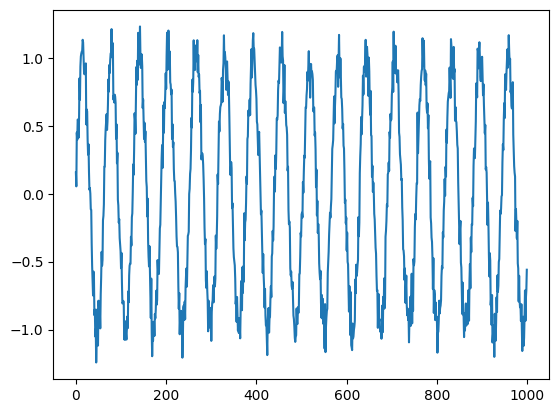

In [54]:
series = np.sin(0.1*np.arange(n)) + np.random.randn(n)*0.1
plt.plot(series)
plt.show()

In [55]:
T = 10
X = []
Y = []
for i in range(len(series)-T):
  x = series[i:i+T]
  X.append(x)
  y = series[i+T]
  Y.append(y)

In [56]:
X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print(X.shape,Y.shape)

(990, 10, 1) (990, 1)


In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [58]:
class SimpleRNN(nn.Module):
  def __init__(self,n_inputs,n_hidden,n_rnnlayers,n_outputs):
    super(SimpleRNN,self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.RNN(input_size = self.D,
                      hidden_size=self.M,
                      num_layers=self.L,
                      nonlinearity='relu',
                      batch_first=True)
    self.fc = nn.Linear(self.M,self.K)
  def forward(self,X):
    h0 = torch.zeros(self.L,X.size(0),self.M)
    out,_ = self.rnn(X,h0)
    out = self.fc(out[:,-1,:])
    return out


In [59]:
model = SimpleRNN(n_inputs=1,n_hidden = 15,n_rnnlayers=1,n_outputs = 1)

In [60]:
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [61]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)


In [62]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [63]:
x_train,y_train = X_train.to(device),y_train.to(device)
x_test,y_test = X_test.to(device),y_test.to(device)

In [64]:
def training(model,criterion,optimizer,X_train,y_train,X_test,y_test,epoochs = 100):
  train_losses = np.zeros(epoochs)
  test_losses = np.zeros(epoochs)

  for i in range(epoochs):
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs,y_train)


    loss.backward()
    optimizer.step()


    train_losses[i] = loss.item()

    test_outputs = model(X_test)

    test_loss = criterion(test_outputs,y_test)
    test_losses[i] = test_loss.item()


    if (i+1) % 5 == 0:
      print(f'Epoch {i+1}/{epoochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses,test_losses


In [65]:
train_losses,test_losses = training(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_train)

Epoch 5/100, Train Loss: 0.5058, Test Loss: 0.5275
Epoch 10/100, Train Loss: 0.4783, Test Loss: 0.5101
Epoch 15/100, Train Loss: 0.4542, Test Loss: 0.4947
Epoch 20/100, Train Loss: 0.4282, Test Loss: 0.4787
Epoch 25/100, Train Loss: 0.3983, Test Loss: 0.4606
Epoch 30/100, Train Loss: 0.3630, Test Loss: 0.4402
Epoch 35/100, Train Loss: 0.3205, Test Loss: 0.4163
Epoch 40/100, Train Loss: 0.2703, Test Loss: 0.3899
Epoch 45/100, Train Loss: 0.2151, Test Loss: 0.3631
Epoch 50/100, Train Loss: 0.1639, Test Loss: 0.3480
Epoch 55/100, Train Loss: 0.1223, Test Loss: 0.3570
Epoch 60/100, Train Loss: 0.0961, Test Loss: 0.3913
Epoch 65/100, Train Loss: 0.0834, Test Loss: 0.4260
Epoch 70/100, Train Loss: 0.0722, Test Loss: 0.4320
Epoch 75/100, Train Loss: 0.0616, Test Loss: 0.4251
Epoch 80/100, Train Loss: 0.0536, Test Loss: 0.4216
Epoch 85/100, Train Loss: 0.0469, Test Loss: 0.4216
Epoch 90/100, Train Loss: 0.0420, Test Loss: 0.4210
Epoch 95/100, Train Loss: 0.0381, Test Loss: 0.4164
Epoch 100/100

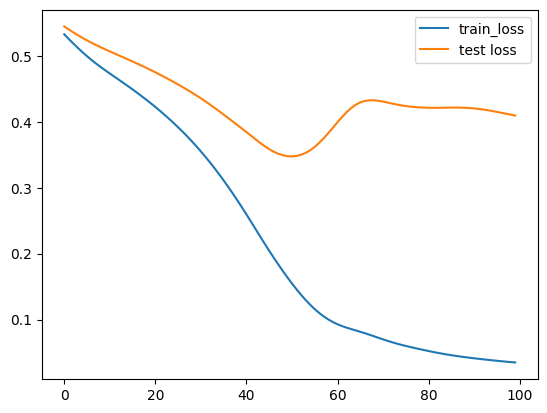

In [66]:
plt.plot(train_losses,label = 'train_loss')
plt.plot(test_losses,label ='test loss')
plt.legend()
plt.show()